<a href="https://colab.research.google.com/github/electropavuk/nn/blob/master/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №6
#### з дисципліни "Нейронні мережі"
#### студента групи КН-31/2
#### Мауріна Андрія
#### Варіант №4

In [30]:
import zipfile
import random
import os
import pathlib


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

!pip install --upgrade tensorflow_hub
import tensorflow_hub as hub

In [31]:
# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-04-17 18:34:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.2’

pizza_steak.zip.2   100%[===================>] 104.47M   209MB/s    in 0.5s    

2022-04-17 18:34:01 (209 MB/s) - ‘pizza_steak.zip.2’ saved [109540975/109540975]



In [32]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [33]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [34]:
data_dir = pathlib.Path("pizza_steak/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


Image shape: (512, 512, 3)


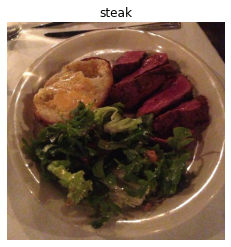

In [35]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir+target_class

    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")

    return img

img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [36]:
num_classes = 2
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [39]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 7, strides=4, activation="selu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 3, activation="selu"),
    tf.keras.layers.MaxPool2D(2, padding="valid"),

    tf.keras.layers.Conv2D(128, 3, activation="selu"),
    tf.keras.layers.MaxPool2D(2, padding="valid"),
    tf.keras.layers.Conv2D(128, 3, activation="selu"),
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(10, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

resnet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),

    tf.keras.layers.Dense(10, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
resnet.build([None, 224, 224, 3])  # Batch input shape.



efficientnet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),
                   
    tf.keras.layers.Dense(10, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
efficientnet.build([None, 224, 224, 3])  # Batch input shape.

In [44]:
names = ('CNN', 'ResNet', 'EfficientNet')
models = (cnn, resnet, efficientnet)

for model, name in zip(models, names):
    print(f'=== {name} ===' * 10, '\n' * 3)
    model.summary()

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True),
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    ]

    history = model.fit(
        train_data,
        epochs=50,
        batch_size=32,
        steps_per_epoch=len(train_data),
        validation_data=valid_data,
        validation_steps=len(valid_data),
        callbacks=callbacks,
    )

    print('\n'*5)
    loss, accuracy = model.evaluate(valid_data)
    print('Model:', name)
    print(f'loss: {loss}\naccuracy: {accuracy}', '\n'*10)

=== CNN ====== CNN ====== CNN ====== CNN ====== CNN ====== CNN ====== CNN ====== CNN ====== CNN ====== CNN === 



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 55, 55, 32)        4736      
                                                                 
 conv2d_17 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
    

### Висновок

При виконанні Лабораторної роботи 6, ми підготували тренувальний та валідаційний датасети для класифікації їжі. 

Застосували згорткові нейронні мережі для класифікації зображень з ЛР5. Також обрали претреновані моделі ResNet і EffecientNet, які були підготовані на датасеті ImageNet. В верхніх шарах цих моделей було відключено тренування і треновані лише останні два повнозв'язних шари.

- CNN 88.4%
- ResNet 99.2%
- EfficientNet 99.6%